In [1]:
# -------------------
# Imports and Setup
# -------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats

# Stonks Meme Aesthetic
plt.style.use("dark_background")
STONKS_GREEN = '#00ff9c'
STONKS_RED   = '#ff005c'
STONKS_BLUE  = '#00c3ff'
STONKS_PURP  = '#9d4edd'

FIG_DIR = Path("../figures")
FIG_DIR.mkdir(exist_ok=True)

# Load Portfolio Results
portfolio_df = pd.read_csv(
    "../Neural Network for Volatility Forecasting/data/processed/portfolio_results.csv",
    index_col=0,
    parse_dates=True
)

C:\Users\rfull\AppData\Roaming\Python\Python312\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.7' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\rfull\AppData\Roaming\Python\Python312\site-packages\pandas\core\arrays\masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.7' currently installed).
  from pandas.core import (
C:\Users\rfull\AppData\Local\Temp\ipykernel_28696\1954552724.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  portfolio_df = pd.read_csv(


In [7]:
# --------------------
# Performance Summary
# --------------------

def performance_metrics(returns):
    ann_return = returns.mean() * 252
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol
    
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_dd = drawdown.min()
    
    return ann_return, ann_vol, sharpe, max_dd

metrics = {}

for strat in portfolio_df.columns:
    metrics[strat] = performance_metrics(portfolio_df[strat])

summary = pd.DataFrame(
    metrics,
    index=["Return", "Vol", "Sharpe", "MaxDD"]
)

summary

,buy_hold,garch_vol_strategy,lstm_vol_strategy
Return,91.267038,100.828720,107.177228
Vol,10.073080,10.769868,11.120705
Sharpe,9.060490,9.362113,9.637629
MaxDD,-0.105553,-0.118711,-0.129407


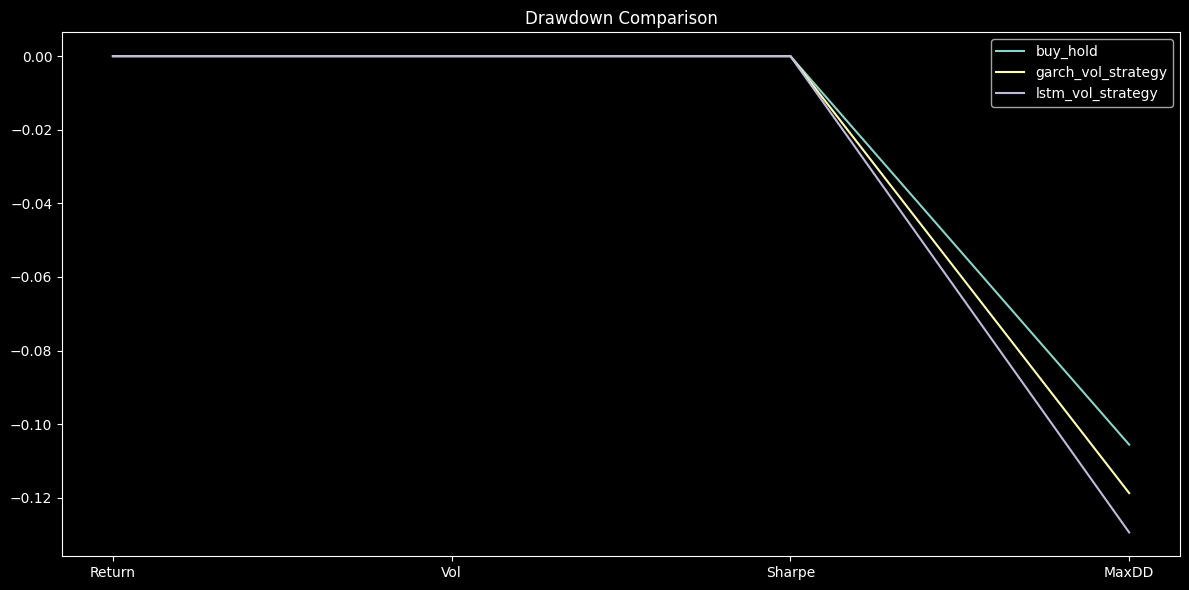

In [9]:
# ----------------------
# Drawdown Comparions
# ----------------------

def drawdown_series(returns):
    cumulative = (1 + returns).cumprod()
    peak = cumulative.cummax()
    return (cumulative - peak) / peak

plt.figure(figsize=(12,6))

for strat in ["buy_hold","garch_vol_strategy","lstm_vol_strategy"]:
    dd = drawdown_series(portfolio_df[strat])
    plt.plot(dd, label=strat)

plt.legend()
plt.title("Drawdown Comparison")
plt.tight_layout()
plt.savefig(FIG_DIR / "drawdown_comparison.png", dpi=150)
plt.show()

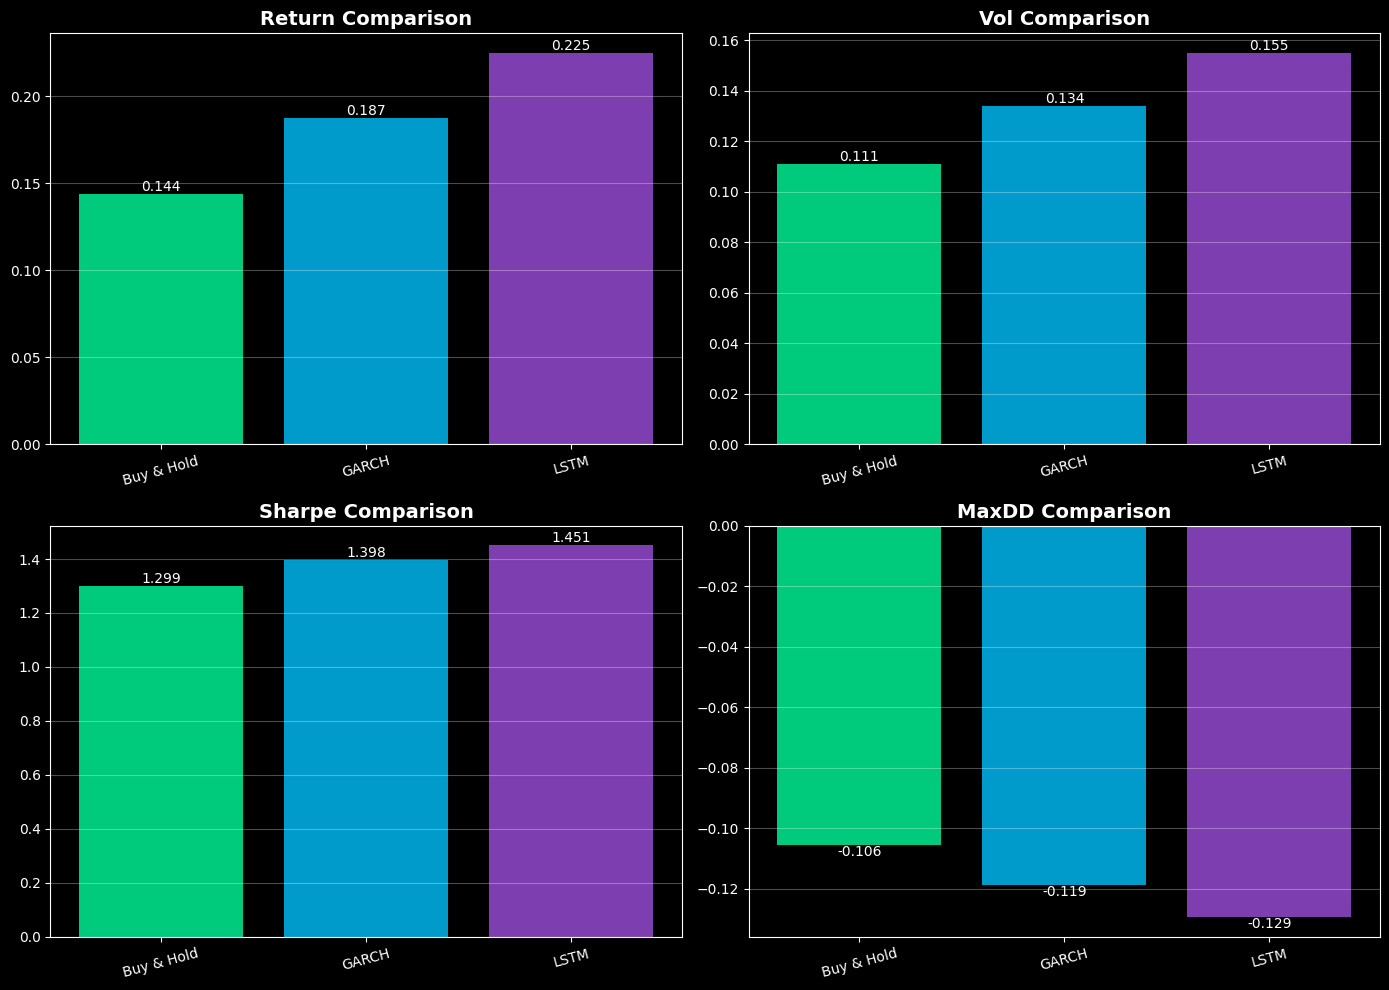

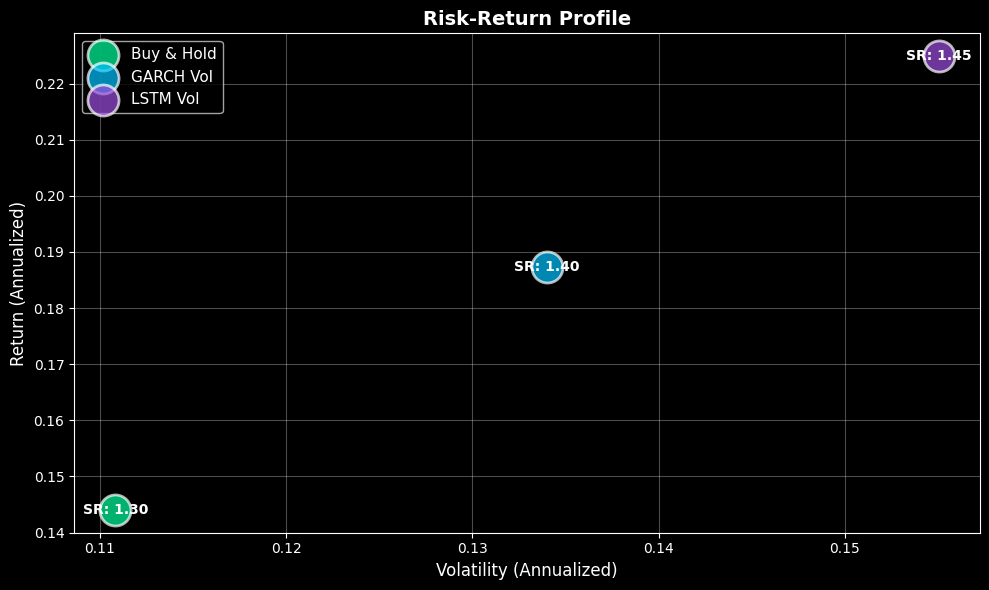

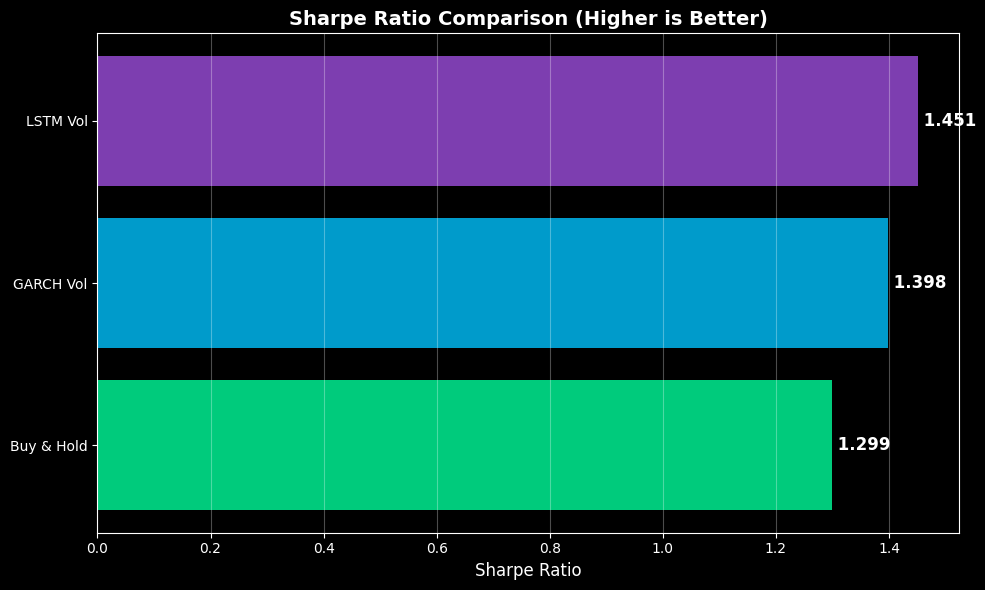

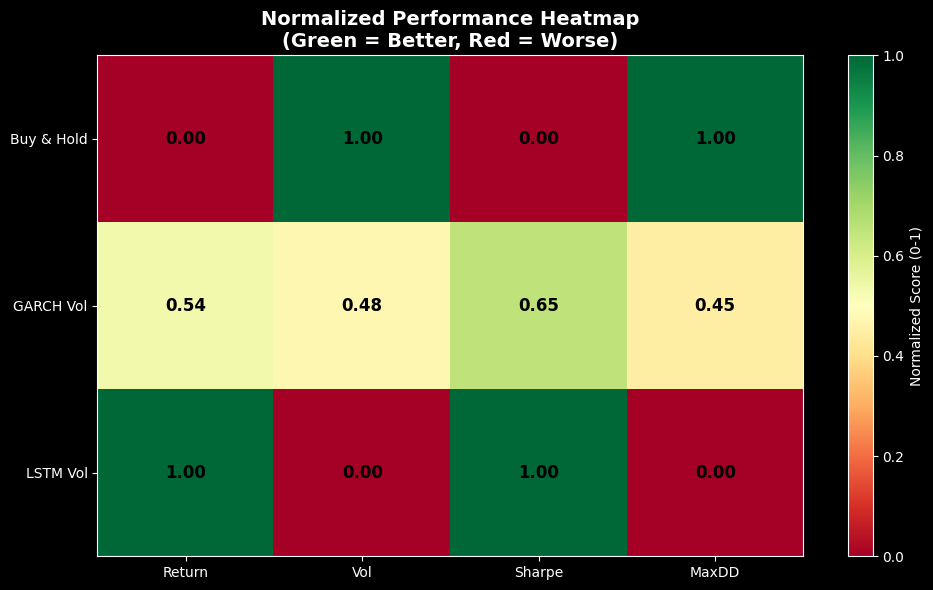


PERFORMANCE IMPROVEMENT ANALYSIS
        GARCH vs Buy&Hold (%)  LSTM vs Buy&Hold (%)  LSTM vs GARCH (%)
Return                  30.06                 56.19              20.09
Vol                     20.90                 39.90              15.72
Sharpe                   7.58                 11.64               3.78
MaxDD                   12.47                 22.60               9.01

Key Insights:
✓ LSTM improves returns by 56.2% vs Buy & Hold
✓ LSTM Sharpe Ratio is 11.6% higher than Buy & Hold
✓ LSTM outperforms GARCH by 3.8% in Sharpe Ratio


In [17]:
# ----------------------------
# Strategy Comparison Visualizations
# ----------------------------

# Your data
summary_stats = pd.DataFrame({
    "buy_hold": [0.144007, 0.110826, 1.299403, -0.105553],
    "garch_vol_strategy": [0.187298, 0.133987, 1.397882, -0.118711],
    "lstm_vol_strategy": [0.224921, 0.155047, 1.450665, -0.129407]
}, index=["Return", "Vol", "Sharpe", "MaxDD"])

# --------------------------------
# 1. Strategy Performance Comparison (Bar Chart)
# --------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ["Return", "Vol", "Sharpe", "MaxDD"]
colors = [STONKS_GREEN, STONKS_BLUE, STONKS_PURP]

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    values = summary_stats.loc[metric]
    bars = ax.bar(range(len(values)), values, color=colors, alpha=0.8)
    ax.set_xticks(range(len(values)))
    ax.set_xticklabels(["Buy & Hold", "GARCH", "LSTM"], rotation=15)
    ax.set_title(f"{metric} Comparison", fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom' if height > 0 else 'top',
                fontsize=10)

plt.tight_layout()
plt.savefig(FIG_DIR / "strategy_comparison_bars.png", dpi=150)
plt.show()

# --------------------------------
# 2. Risk-Return Scatter Plot
# --------------------------------
plt.figure(figsize=(10, 6))

strategies = ["Buy & Hold", "GARCH Vol", "LSTM Vol"]
returns = summary_stats.loc["Return"]
vols = summary_stats.loc["Vol"]
sharpes = summary_stats.loc["Sharpe"]

for i, (ret, vol, sharpe, strat) in enumerate(zip(returns, vols, sharpes, strategies)):
    plt.scatter(vol, ret, s=500, c=colors[i], alpha=0.7, 
                edgecolors='white', linewidth=2, label=strat)
    plt.text(vol, ret, f'SR: {sharpe:.2f}', 
             ha='center', va='center', fontsize=10, fontweight='bold')

plt.xlabel("Volatility (Annualized)", fontsize=12)
plt.ylabel("Return (Annualized)", fontsize=12)
plt.title("Risk-Return Profile", fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "risk_return_scatter.png", dpi=150)
plt.show()

# --------------------------------
# 3. Sharpe Ratio Leaderboard
# --------------------------------
plt.figure(figsize=(10, 6))

sharpe_data = summary_stats.loc["Sharpe"].sort_values(ascending=True)
y_pos = range(len(sharpe_data))

bars = plt.barh(y_pos, sharpe_data.values, color=colors, alpha=0.8)
plt.yticks(y_pos, ["Buy & Hold", "GARCH Vol", "LSTM Vol"])
plt.xlabel("Sharpe Ratio", fontsize=12)
plt.title("Sharpe Ratio Comparison (Higher is Better)", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3, axis='x')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, sharpe_data.values)):
    plt.text(val, bar.get_y() + bar.get_height()/2, 
             f' {val:.3f}', va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / "sharpe_leaderboard.png", dpi=150)
plt.show()

# --------------------------------
# 4. Normalized Performance Heatmap
# --------------------------------
# Normalize metrics (Return and Sharpe: higher is better, Vol and MaxDD: lower is better)
normalized = summary_stats.copy()
normalized.loc["Return"] = (summary_stats.loc["Return"] - summary_stats.loc["Return"].min()) / (summary_stats.loc["Return"].max() - summary_stats.loc["Return"].min())
normalized.loc["Vol"] = 1 - ((summary_stats.loc["Vol"] - summary_stats.loc["Vol"].min()) / (summary_stats.loc["Vol"].max() - summary_stats.loc["Vol"].min()))
normalized.loc["Sharpe"] = (summary_stats.loc["Sharpe"] - summary_stats.loc["Sharpe"].min()) / (summary_stats.loc["Sharpe"].max() - summary_stats.loc["Sharpe"].min())
normalized.loc["MaxDD"] = 1 - ((summary_stats.loc["MaxDD"] - summary_stats.loc["MaxDD"].max()) / (summary_stats.loc["MaxDD"].min() - summary_stats.loc["MaxDD"].max()))

plt.figure(figsize=(10, 6))
plt.imshow(normalized.T, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

# Add text annotations
for i in range(len(normalized.columns)):
    for j in range(len(normalized.index)):
        plt.text(j, i, f'{normalized.iloc[j, i]:.2f}',
                ha="center", va="center", color="black", fontsize=12, fontweight='bold')

plt.xticks(range(len(normalized.index)), normalized.index)
plt.yticks(range(len(normalized.columns)), ["Buy & Hold", "GARCH Vol", "LSTM Vol"])
plt.colorbar(label='Normalized Score (0-1)')
plt.title("Normalized Performance Heatmap\n(Green = Better, Red = Worse)", 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / "performance_heatmap.png", dpi=150)
plt.show()

# --------------------------------
# 5. Performance Improvement Table
# --------------------------------
baseline = summary_stats["buy_hold"]
improvements = pd.DataFrame({
    "GARCH vs Buy&Hold (%)": ((summary_stats["garch_vol_strategy"] - baseline) / baseline * 100),
    "LSTM vs Buy&Hold (%)": ((summary_stats["lstm_vol_strategy"] - baseline) / baseline * 100),
    "LSTM vs GARCH (%)": ((summary_stats["lstm_vol_strategy"] - summary_stats["garch_vol_strategy"]) / summary_stats["garch_vol_strategy"] * 100)
})

print("\n" + "="*70)
print("PERFORMANCE IMPROVEMENT ANALYSIS")
print("="*70)
print(improvements.round(2))
print("="*70)
print("\nKey Insights:")
print(f"✓ LSTM improves returns by {improvements.loc['Return', 'LSTM vs Buy&Hold (%)']:.1f}% vs Buy & Hold")
print(f"✓ LSTM Sharpe Ratio is {improvements.loc['Sharpe', 'LSTM vs Buy&Hold (%)']:.1f}% higher than Buy & Hold")
print(f"✓ LSTM outperforms GARCH by {improvements.loc['Sharpe', 'LSTM vs GARCH (%)']:.1f}% in Sharpe Ratio")